In [1]:
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from cytograph.pipeline import load_config, PunchcardDeck
from cytograph.plotting import colorize
from cytograph.embedding import art_of_tsne
from cytograph.visualization import scatterm
from cytograph.species import Species
from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import networkx as nx

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [2]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/figure3'

In [3]:
# get ncRNA gene names
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    accession_dict = dict(zip(
        pd.Series(ds.ra.Accession).str.split('.').str[0],
        np.arange(ds.shape[0])
    ))
    ncRNA_genes = np.loadtxt('ncRNA.txt', dtype='object')
    accession_ix = np.array([accession_dict.get(x, '') for x in ncRNA_genes])
    accession_ix = accession_ix[accession_ix != ''].astype('int')
    ncRNA_genes = ds.ra.Gene[accession_ix]

In [4]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [5]:
def go_plot(table, n_top=25, filename=None):
    
    top = table.sort_values('adj_p_val')[:n_top][::-1]
    
    plt.figure(None, (1, 3))
    
    ax = plt.subplot(122)
    plt.barh(range(n_top), top['adj_p_val'].to_numpy(), color='grey', alpha=0.3)
    plt.vlines(0.05, -0.5, n_top-0.5, linestyles='dashed', colors=cbl[2])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks([])
    plt.xticks(np.round(np.linspace(0, top['adj_p_val'].max(), 4), 2), rotation=90, fontsize=7)
    plt.margins(y=0.01)
    
    ax = plt.subplot(121)
    n_genes = top['overlapping_genes'].str.len().to_numpy()
    plt.barh(range(n_top), -n_genes, alpha=0.3, color='grey')
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks(range(n_top), top['path_name'].str.split('(').str[0].str.strip(), fontsize=9)
    plt.xticks(
        -np.linspace(0, n_genes.max(), 4),
        np.round(np.linspace(0, n_genes.max(), 4), 2),
        rotation=90,
        fontsize=7
    )
    plt.margins(y=0.01)
    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

In [6]:
def skeletonize(nn, groups, labels, min_pct=1):
    
    row = []
    col = []
    weight = []
    
    for i, c1 in enumerate(groups):
        n_c1 = (labels == c1).sum()
        rc1 = labels[nn.row] == c1
        cc1 = labels[nn.col] == c1
        c1_internal = (rc1 & cc1).sum()
        for j, c2 in enumerate(groups):
            n_c2 = (labels == c2).sum()
            rc2 = labels[nn.row] == c2
            cc2 = labels[nn.col] == c2
            c2_internal = (rc2 & cc2).sum()
            c1c2_between = ((rc1 & cc2) | (rc2 & cc1)).sum()
            f = n_c1 / (n_c1 + n_c2)
            expected_fraction = (2 * f - 2 * f**2)
            observed_fraction = c1c2_between / (c1_internal + c2_internal + c1c2_between)
            # if observed_fraction > expected_fraction * (self.min_pct / 100):
            if observed_fraction > (min_pct / 100):
                row.append(i)
                col.append(j)
                weight.append(observed_fraction / expected_fraction)
                
    # make matrix of edges            
    n_clusters = len(groups)
    overlap = sparse.coo_matrix((weight, (row, col)), shape=(n_clusters, n_clusters)).A
    
    # remove edges within a group
    np.fill_diagonal(overlap, 0)
    
    return overlap

In [7]:
def clean_roi(roi_attr):
    return pd.Series(roi_attr).replace({r'[^\x00-\x7F]+':''}, regex=True).to_numpy()

# Fibroblasts

9156


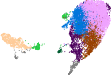

In [11]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_H_Clean.loom', 'r') as ds:

    print(ds.shape[1])

    labels = ds.ca.Clusters
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.UMAP[cells, 0], ds.ca.UMAP[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    
    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    #plt.savefig(f'{figure_folder}/astrocyte_clusters.pdf', dpi=300)

# Vascular

9932


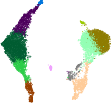

In [12]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_E_Clean.loom', 'r') as ds:

    print(ds.shape[1])

    labels = ds.ca.Clusters
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.UMAP[cells, 0], ds.ca.UMAP[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    
    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    #plt.savefig(f'{figure_folder}/astrocyte_clusters.pdf', dpi=300)

# Resident macrophages

91838


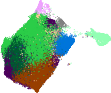

In [13]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_B_Clean.loom', 'r') as ds:

    print(ds.shape[1])

    labels = ds.ca.Clusters
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.UMAP[cells, 0], ds.ca.UMAP[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    
    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    #plt.savefig(f'{figure_folder}/astrocyte_clusters.pdf', dpi=300)